# <center>Udacity Machine Learning Nanodegree Capstone Project</center>
## <center>David S. Price - June 2019</center>

This project was inspired by a Kaggle competition project called <a href="https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria">“Malaria Cell Images Dataset - Cell Images for Detecting Malaria”</a>.  The intent is to save humans by developing an algorithm to determine whether image cells show infestation by malaria. The dataset of images (which actually comes from the NIH) contains cell images in two categories – those parasitized by malaria and those uninfected.

In this notebook, first a one-layer convolutional neural network (CNN) is developed and trained to serve as a benchmark.  Then a 3-layer fully connected CNN is developed and trained to detect the differences in the cell images.  The full database is fairly large, containing 27,558 images evenly divided between parasitized and uninfected cells.  This database is allocated as follows:
* Train Images - 70% - 19,290 total images (9645 each for parasitized and uninfected)
* Validation Images - 10% - 2,756 total images (1378 each for parasitized and uninfected)
* Test Images - 20% - 5,512 total images (2756 each for parasitized and uninfected)

The code allows for the option to run just a subset of the images, which can be quite useful when further developing the code structure and quick feedback is valuable.  The subset database is fairly small, containing only 200 images evenly divided between parasitized and uninfected cells.  This database is allocated as follows:
* Train Images - 70% - 140 total images (70 each for parasitized and uninfected)
* Validation Images - 10% - 20 total images (10 each for parasitized and uninfected)
* Test Images - 20% - 40 total images (20 each for parasitized and uninfected)

The code is structured to also allow the user to create benchmark performance on the selected dataset using a one-layer CNN.  These are all control parameters the user can set in one of the early code cells.


## Top Level View of Processing

The code in this notebook is structured as follows:
* Import needed libraries and packages
* Establish Control Parameters for the various output options available
* Pre-Process Cell Images
* Set training parameters
* Data Visualization
* Create and Run CNN Model (Benchmark and Full)
  * Create and compile a three-layer fully-connected CNN model
  * Train the full CNN model and save best weights
  * Load the full model weights with the best validation loss
  * Run the predict_generator method to create the full model's prediction file (for use later to produce the ROC and CM)
  * Calculate the Classification Accuracy on the Test Set
* Evaluate model's performance:
  * Receiver Operating Characteristic Curve (ROC)
  * Confusion Matrix (CM)
  
The code is structured such that it expects the following subfolders to exist:
* /cell_images_full - for storing the complete set of images (all 27k images) - more details below
* /cell_images_subset - for storing a subset of images (200 images) - more details below
* /prediction_files - for storing the prediction from the models using the test set of images
* /ground_truth_files - for storing the "truth" of image classification (parasitized or uninfected)
* /saved_models - for storing the best weights from each model

## Import needed libraries and packages

In [11]:
#Import the Keras libraries and packages
import keras
from keras.callbacks import ModelCheckpoint 
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

#import others
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from sklearn.datasets import load_files
from sklearn.metrics import roc_curve, auc, confusion_matrix
import sys


## Establish Control Parameters for the various output options available

Given the enormous size of the image database, it's important to know in advance what the user intends to accomplish with running the code in this notebook as forgetting a parameter can lead to hours of processing which may not be desired at that time.

The user may set the following parameters in this section:

* USE_FULL_IMAGE_SET
  * True = evaluate full image set (>27k files)
  * False = evaluate just a subset image set (200 files)

* RUN_BENCHMARK_CODE
  * True = run the "benchmark" code in the notebook to establish the 1-layer CNN benchmark performance
  * False = do not run the benchmark code


In [12]:
#Set parameter to either evaluate full image set (>27k files) or just a subset (200 files) 
#for algorithm development
USE_FULL_IMAGE_SET = True

#Set parameter to run benchmark code
RUN_BENCHMARK_CODE = True

#Echo settings to user
print("USE_FULL_IMAGE_SET : ",USE_FULL_IMAGE_SET)
print("RUN_BENCHMARK_CODE : ",RUN_BENCHMARK_CODE)

USE_FULL_IMAGE_SET :  True
RUN_BENCHMARK_CODE :  True


## Pre-Process Cell Images

### Set Image File Path

First, set the image file path according to the setting of USE_FULL_IMAGE_SET.  The images must be in the following folder structure of the same folder in which the notebook is being run:
* /cell_images_full
  * /train
    * /parasitized - 9645 images
    * /uninfected - 9645 images
  * /test
    * /parasitized - 2756 images
    * /uninfected - 2756 images
  * /valid
    * /parasitized - 1378 images
    * /uninfected - 1378 images
* /cell_images_subset
  * /train
    * /parasitized - 70 images
    * /uninfected - 70 images
  * /test
    * /parasitized - 20 images
    * /uninfected - 20 images
  * /valid
    * /parasitized - 10 images
    * /uninfected - 10 images

The "ground truth" files used by the program only contain the classication of the test dataset from the full and subsets of images, but for a complete listing of how the images were divided between the train, validation, and test datasets, refer to the following files:
* /ground_truth_files/ground_truth_full - COMPLETE.xls
* /ground_truth_files/ground_truth_subset - COMPLETE.xls

### Create Tensor Image Data
Next, call ImageDataGenerator to generate batches of tensor image data with real-time data augmentation for the train, valid, and test sets.

### Create Tuples of Data for Each Image Data Set
Lastly, apply method "flow_from_directory" which takes the path to a directory & generates batches of augmented data, returning a "DirectoryIterator" yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, target_size, channels) and y is a numpy array of corresponding labels.  Do this to create the training_set, valid_set, and test_set.

In [13]:
#Set image file path accordingly
if USE_FULL_IMAGE_SET == True:
    print("Using FULL image set\n")
    training_set_image_path = 'cell_images_full/train'
    validation_set_image_path = 'cell_images_full/valid'
    test_set_image_path = 'cell_images_full/test'
    
else:
    print("Using small SUBSET image set\n")
    training_set_image_path = 'cell_images_subset/train'
    validation_set_image_path = 'cell_images_subset/valid'
    test_set_image_path = 'cell_images_subset/test'

#Call ImageDataGenerator to generate batches of tensor image data with real-time 
#data augmentation. The data will be looped over (in batches).

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen = ImageDataGenerator(rescale = 1./255)


#Apply method "flow_from_directory"

BATCH_SIZE = 32

training_set = train_datagen.flow_from_directory(training_set_image_path, 
                                                 target_size = (64, 64), 
                                                 batch_size = BATCH_SIZE, 
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(validation_set_image_path, 
                                                        target_size = (64, 64), 
                                                        batch_size = BATCH_SIZE, 
                                                        class_mode = 'categorical')

#Set batch_size to 1 to force 1 entry per image - critical for the prediction step later on
test_set = test_datagen.flow_from_directory(test_set_image_path, 
                                            target_size = (64, 64), 
                                            batch_size = 1, 
                                            class_mode = 'categorical')

print("\nFinished pre-processing cell images")

Using FULL image set

Found 19290 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.

Finished pre-processing cell images


## Set training parameters

First, set the following parameters based on the length (i.e. number of files) of the datasets:
* NUMBER_TEST_SET_SAMPLES = length of the test dataset
* NUMBER_VALIDATION_SET_SAMPLES = length of validation dataset

Then, set the following training parameters:
* BATCH_SIZE = 10
* NUMBER_STEPS_PER_EPOCH = NUMBER_TEST_SET_SAMPLES/BATCH_SIZE
* NUMBER_OF_EPOCHS = 10
* NUMBER_VALIDATION_STEPS = NUMBER_VALIDATION_SET_SAMPLES/BATCH_SIZE


In [14]:
#Establish length of train, validation, and test datasets

train_filenames = training_set.filenames
NUMBER_TRAIN_SET_SAMPLES = len(train_filenames)
print("# of training dataset samples = ",NUMBER_TRAIN_SET_SAMPLES)

valid_filenames = validation_set.filenames
NUMBER_VALIDATION_SET_SAMPLES = len(valid_filenames)
print("# of validation dataset samples = ",NUMBER_VALIDATION_SET_SAMPLES)

test_filenames = test_set.filenames
NUMBER_TEST_SET_SAMPLES = len(test_filenames)
print("# of test dataset samples = ",NUMBER_TEST_SET_SAMPLES)

#Set Training Parameters
BATCH_SIZE = 10
NUMBER_STEPS_PER_EPOCH = NUMBER_TEST_SET_SAMPLES/BATCH_SIZE
NUMBER_OF_EPOCHS = 10
NUMBER_VALIDATION_STEPS = NUMBER_VALIDATION_SET_SAMPLES/BATCH_SIZE

#Echo results to user
print("# of images per batch : ", BATCH_SIZE)
print("# of steps per epoch  : ", NUMBER_STEPS_PER_EPOCH)
print("# of epochs           : ", NUMBER_OF_EPOCHS)
print("# of validation steps : ", NUMBER_VALIDATION_STEPS)

# of training dataset samples =  19290
# of validation dataset samples =  2756
# of test dataset samples =  5512
# of images per batch :  10
# of steps per epoch  :  551.2
# of epochs           :  10
# of validation steps :  275.6


## Data Visualization

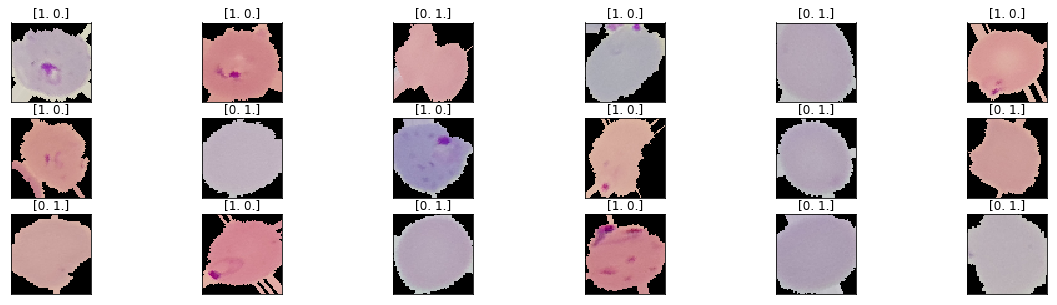

In [15]:
#Plot the first 18 training images, including class or label where:
#  [1,0] = parasitized
#  [0,1] = uninfected

fig = plt.figure(figsize=(20,5))
for i in range(18):
    x,y = training_set.next()
    for j in range(0,1):
        image = x[j]
        ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(x[j]))
        ax.set_title(str(y[j]))
plt.show()


## Create and Run Benchmark CNN Model

If the RUN_BENCHMARK_CODE parameter is set, then go through the following steps to establish a benchmark performance:

1. Create and compile a one-layer CNN model
2. Train the benchmark CNN model and save best weights
3. Load the benchmark model weights with the best validation loss
4. Run the predict_generator method to create the benchmark_prediction file (for use later to produce the ROC and CM)
5. Calculate the Classification Accuracy on the Test Set


In [16]:
#Benchmark CNN Step 1. Create and compile a one-layer CNN model

if RUN_BENCHMARK_CODE == True:
    #Initialize the CNN
    benchmark_model = Sequential()

    #Add convolution layer
    benchmark_model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

    #Add pooling layer
    benchmark_model.add(MaxPooling2D(pool_size = (2, 2)))

    #Add flattening layer
    benchmark_model.add(Flatten())

    #Add fully connected layer
    benchmark_model.add(Dense(units = 128, activation = 'relu'))
    benchmark_model.add(Dense(units = 2, activation = 'softmax'))

    #Print model summary
    benchmark_model.summary()

    #Compile the CNN
    benchmark_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    print("\nFinished compiling benchmark model")
    
else:
    print("Not running benchmark code")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 3,937,538.0
Trainable params: 3,937,538.0
Non-trainable params: 0.0
_________________________________________________________________

Finished compiling benchmark model


In [17]:
#Benchmark CNN Step 2. Train the benchmark CNN model and save best weights

# train the benchmark model if mode activated
if RUN_BENCHMARK_CODE == True:
    benchmark_checkpointer = ModelCheckpoint(filepath='saved_models/benchmark_model.weights.best.hdf5', 
                                             verbose=1, 
                                             save_best_only=True)

    #Fit the benchmark model
    benchmark_model.fit_generator(training_set, 
                                  steps_per_epoch = NUMBER_STEPS_PER_EPOCH, 
                                  epochs = NUMBER_OF_EPOCHS, 
                                  callbacks=[benchmark_checkpointer], 
                                  validation_data = validation_set, 
                                  validation_steps = NUMBER_VALIDATION_STEPS)

    print("\nFinished benchmark model fitting of malaria-infected cell images to one-layer CNN")
    
else:
    print("Not running benchmark code")

Epoch 1/10
552/551 [==============================] - 825s - loss: 0.6184 - acc: 0.6727 - val_loss: 0.7746 - val_acc: 0.5521
Epoch 2/10
552/551 [==============================] - 1017s - loss: 0.5115 - acc: 0.7606 - val_loss: 0.7073 - val_acc: 0.6092
Epoch 3/10
552/551 [==============================] - 831s - loss: 0.4108 - acc: 0.8257 - val_loss: 0.5988 - val_acc: 0.6916
Epoch 4/10
552/551 [==============================] - 328s - loss: 0.3243 - acc: 0.8714 - val_loss: 0.4625 - val_acc: 0.7699
Epoch 5/10
552/551 [==============================] - 207s - loss: 0.2758 - acc: 0.8983 - val_loss: 0.4123 - val_acc: 0.7940
Epoch 6/10
552/551 [==============================] - 177s - loss: 0.2408 - acc: 0.9155 - val_loss: 0.4545 - val_acc: 0.7962
Epoch 7/10
552/551 [==============================] - 187s - loss: 0.2232 - acc: 0.9238 - val_loss: 0.4318 - val_acc: 0.8019
Epoch 8/10
552/551 [==============================] - 197s - loss: 0.2038 - acc: 0.9312 - val_loss: 0.4498 - val_acc: 0.8133

In [18]:
#Benchmark CNN Step 3. Load the benchmark model weights with the best validation loss

# Load the benchmark model weights with the best validation loss if mode activated
if RUN_BENCHMARK_CODE == True:
    benchmark_model.load_weights('saved_models/benchmark_model.weights.best.hdf5')
    print("Loaded benchmark model weights")

else:
    print("Not running benchmark code")

Loaded benchmark model weights


In [19]:
#Benchmark CNN Step 4. Run the predict_generator method to create the benchmark_prediction file

#Run prediction generator (for use with ROC and CM later) if mode activated
if RUN_BENCHMARK_CODE == True:

    benchmark_predict = benchmark_model.predict_generator(test_set,steps = NUMBER_TEST_SET_SAMPLES)

    print("Finished with benchmark predict generator")
    print("benchmark.predict.shape is: ",benchmark_predict.shape)
    print('benchmark_predict content:')
    print(benchmark_predict)
else:
    print("Not running benchmark code")

Finished with benchmark predict generator
benchmark.predict.shape is:  (5512, 2)
benchmark_predict content:
[[0.92464083 0.07535913]
 [0.9832092  0.01679082]
 [0.38922024 0.61077976]
 ...
 [0.82465357 0.17534639]
 [0.9368796  0.0631204 ]
 [0.07422816 0.9257718 ]]


In [20]:
#Benchmark CNN Step 5. Calculate the Classification Accuracy on the Test Set

if RUN_BENCHMARK_CODE == True:
    benchmark_score = benchmark_model.evaluate_generator(test_set, steps = NUMBER_TEST_SET_SAMPLES)

    benchmark_accuracy = 100*benchmark_score[1]

    print('Benchmark Test accuracy: %.4f%%' % benchmark_accuracy)
    
else:
    print("Not running benchmark code")

Benchmark Test accuracy: 88.2801%


## Create and Run Full CNN Model

Go through the following steps to establish the full model and its performance:

1. Create and compile a three-layer fully-connected CNN model
2. Train the full CNN model and save best weights
3. Load the full model weights with the best validation loss
4. Run the predict_generator method to create the full model's prediction file (for use later to produce the ROC and CM)
5. Calculate the Classification Accuracy on the Test Set

In [21]:
#Full CNN Step 1. Create and compile a three-layer fully-connected CNN model

#Initialize the CNN
model = Sequential()

#Add 1st convolutional layer
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Add 2nd convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Add 3rd convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Add fully connected layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 2, activation = 'softmax'))

#Print model summary
model.summary()

#Compile the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print("\nFinished compiling full model")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
__________

In [22]:
#Full CNN Step 2. Train the full CNN model and save best weights

#Train the model
checkpointer = ModelCheckpoint(filepath='saved_models/model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
    
#Fit the model
model.fit_generator(training_set, 
                    steps_per_epoch = NUMBER_STEPS_PER_EPOCH, 
                    epochs = NUMBER_OF_EPOCHS, 
                    callbacks=[checkpointer], 
                    validation_data = validation_set, 
                    validation_steps = NUMBER_VALIDATION_STEPS)

print("\nFinished full model fitting of malaria-infected cell images to 3 layer CNN")

Epoch 1/10
552/551 [==============================] - 161s - loss: 0.4461 - acc: 0.7801 - val_loss: 0.3442 - val_acc: 0.8359
Epoch 2/10
552/551 [==============================] - 149s - loss: 0.2149 - acc: 0.9309 - val_loss: 0.2724 - val_acc: 0.8706
Epoch 3/10
552/551 [==============================] - 157s - loss: 0.1735 - acc: 0.9442 - val_loss: 0.2543 - val_acc: 0.9160
Epoch 4/10
552/551 [==============================] - 155s - loss: 0.1673 - acc: 0.9466 - val_loss: 0.2030 - val_acc: 0.9347
Epoch 5/10
552/551 [==============================] - 154s - loss: 0.1568 - acc: 0.9514 - val_loss: 0.2189 - val_acc: 0.9275
Epoch 6/10
552/551 [==============================] - 150s - loss: 0.1533 - acc: 0.9508 - val_loss: 0.2225 - val_acc: 0.9248
Epoch 7/10
552/551 [==============================] - 160s - loss: 0.1478 - acc: 0.9526 - val_loss: 0.2227 - val_acc: 0.9247
Epoch 8/10
552/551 [==============================] - 158s - loss: 0.1454 - acc: 0.9527 - val_loss: 0.2260 - val_acc: 0.9302


In [23]:
#Full CNN Step 3. Load the full model weights with the best validation loss

# Load the model weights with the best validation loss.
model.load_weights('saved_models/model.weights.best.hdf5')

print("Loaded full model weights")

Loaded full model weights


In [24]:
#Full CNN Step 4. Run the predict_generator method to create the full model's prediction file
#(for use later to produce the ROC and CM)

predict = model.predict_generator(test_set,steps = NUMBER_TEST_SET_SAMPLES)

print("Finished with predict generator")
print("predict.shape is: ",predict.shape)
print('predict content:')
print(predict)

Finished with predict generator
predict.shape is:  (5512, 2)
predict content:
[[9.9997616e-01 2.3834062e-05]
 [5.9078086e-02 9.4092196e-01]
 [2.6941800e-01 7.3058200e-01]
 ...
 [1.9121202e-02 9.8087883e-01]
 [2.4170401e-02 9.7582960e-01]
 [9.9904603e-01 9.5394021e-04]]


In [25]:
#Full CNN Step 5. Calculate the Classification Accuracy on the Test Set

score = model.evaluate_generator(test_set, steps = NUMBER_TEST_SET_SAMPLES)

accuracy = 100*score[1]

print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 95.3193%


## Evaluate Model's Performance

Finally, each model's performance is evaluated using the following techniques against the "ground truth":
  * Receiver Operating Characteristic curve (ROC)
  * Confusion Matrix (CM)
  
An ROC curve is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), illustrating the diagnostic ability of a binary classifier system.  Reference: <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">“ROC definition”</a>

The confusion matrix is a table that provides a visual view of how well the model predicts the actual class from an algorithm by clearly depicting the true and false positives,  and the true and false negatives.  Reference: <a href="https://en.wikipedia.org/wiki/Confusion_matrix">“Confusion Matrix definition”</a>

<img src="confusion_matrix.jpg" width="300">

The "ground truth" is actually a .csv file produced to contain every single image in the Test folder (with a separate file for the full set of test images and another for the subset test images), clearly indicating whether the image came from the parasitized classification or the uninfected classification.

Both the ground truth and predictions files are designed to use a binary one-hot encoding scheme, where "task_1" and "task_2" are set as follows: parasitized = [1, 0] and uninfected = [0, 1].

## Function to produce a predictions .csv file for use with ROC and CM

In [26]:
def produce_predictions_file(benchmark = False):
    # This function produces the predictions .csv file for either the benchmark data
    # or the mainline data via the parameter setting in the calling function.  The output is
    # a binary one-hot encoded file suitable for comparison against the ground_truth file.
    
    # Create dataframes to hold predictions
    y_pred = pd.DataFrame(columns=["id","task_1", "task_2"])
    y_pred_sorted = pd.DataFrame(columns=["id","task_1", "task_2"])
    ground_truth = pd.DataFrame(columns=["id","task_1", "task_2"])
    
    # Set the variable predict_file to either the benchmark or model predictions
    if benchmark == True:
        predict_file = benchmark_predict
        print('producing benchmark_predictions.csv')
    else:
        predict_file = predict
        print('producing predictions.csv')

    #print("predict_file contents:")
    #print(predict_file)
    
    #Prepare y_pred file to contain binary one-hot encoding:
    #     id - image filaname
    #     task_1 : 1 if probability of being parasitized is >= 50%; else 0
    #     task_2 : 0 if probability of being parasitized is >= 50%; else 1
    #So, [1 0] means cell is parasitized and [0 1] means uninfected

    for ii in range(len(predict_file)):
        y_pred.loc[ii, "id"] = test_filenames[ii]
        if predict_file[ii][0] >= 0.5:
            y_pred.loc[ii, "task_1"] = 1
            y_pred.loc[ii, "task_2"] = 0
        else:
            y_pred.loc[ii, "task_1"] = 0
            y_pred.loc[ii, "task_2"] = 1

    #Export data into a .csv file
    if benchmark == True:
        y_pred.to_csv("prediction_files/benchmark_predictions.csv")
    else:
        y_pred.to_csv("prediction_files/predictions.csv")

## Produce predictions file in .csv format

In [27]:
# Produce a predictions file for the benchmark code (if needed) for use in ROC and CM.
# The resultant predictions file is a binary one-hot encoded file suitale for comparison
# against the appropriate ground_truth file.
if RUN_BENCHMARK_CODE == True:
    produce_predictions_file(True)
    print("Produced benchmark_predictions .csv file\n")

produce_predictions_file(False)
print("Produced predictions .csv file")


producing benchmark_predictions.csv
Produced benchmark_predictions .csv file

producing predictions.csv
Produced predictions .csv file


## Functions to produce ROC Curves and Confusion Matrix

In [28]:
def plot_roc_curves(y_true, y_pred):
    # This function plots the Receiver Operating Characteristics (ROC) curves and provides the scores.

    # Initialize dictionaries for false and true positive rates and 
    # the ROC Area Under the Curve (AUC) array
    false_positive_rate = dict()
    true_positive_rate = dict()
    area_under_curve = np.zeros(3)
    
    # Prepare the figure for plotting
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # For both classifications (categories "parasitized" and "uninfected"), process data
    # to plot the ROC curve
    for i in range(2):
        # obtain ROC curve
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        area_under_curve[i] = auc(false_positive_rate[i], true_positive_rate[i])
        # plot ROC curve
        plt.plot(false_positive_rate[i], true_positive_rate[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=area_under_curve[i]))
    # Get score for category 3
    area_under_curve[2] = np.average(area_under_curve[:2])
    
    # Next, further format the figure for plotting and then plot
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # Print meaning of scores
    print('Category 1 : Parasitized Cell Images')
    print('Category 2 : Uninfected Cell Images')
    print('Category 3 : Average\n')
    
    # Print the scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=area_under_curve[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    # This function plots the (normalized) confusion matrix using the 
    # true and predicted classifications

    # Obtain class predictions from probabilities for unnormalized confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Now, normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Plot the text to overlay on the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Produce Receiver Operating Characteristics (ROC) curve and the Confusion Matrix

C:\Users\david\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\david\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


ROC and confusion matrix for Benchmark


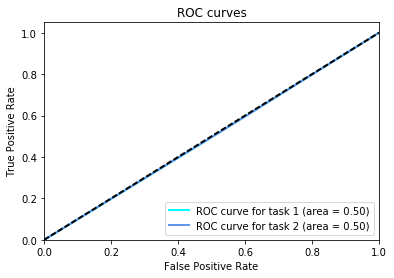

Category 1 : Parasitized Cell Images
Category 2 : Uninfected Cell Images
Category 3 : Average

Category 1 Score: 0.497
Category 2 Score: 0.497
Category 3 Score: 0.497


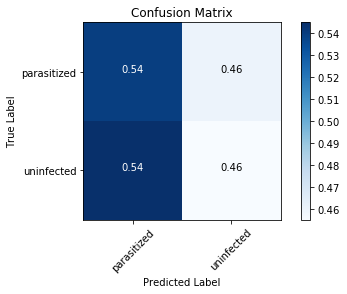

Finished producing benchmark ROC and CM

ROC and confusion matrix for full model


C:\Users\david\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


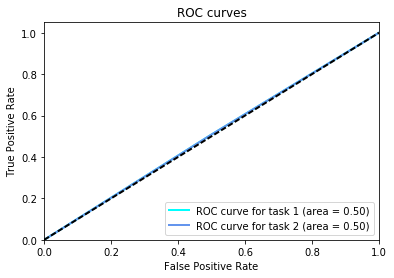

Category 1 : Parasitized Cell Images
Category 2 : Uninfected Cell Images
Category 3 : Average

Category 1 Score: 0.504
Category 2 Score: 0.504
Category 3 Score: 0.504


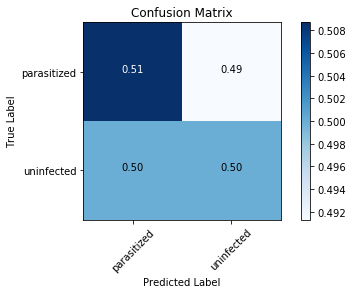

In [29]:
# Set the threshold to the midpoint of the probabilities
thresh = 0.5

# Load the ground truth labels for test dataset
if USE_FULL_IMAGE_SET == True:
    truth = pd.read_csv('ground_truth_files/ground_truth_full.csv')    
else:
    truth = pd.read_csv('ground_truth_files/ground_truth_subset.csv')

y_true = truth.as_matrix(columns=["task_1", "task_2"])

# If running benchmark code, then create ROC and confusion matrix for Benchmark code
if RUN_BENCHMARK_CODE == True:
    print("ROC and confusion matrix for Benchmark")
    # get model predictions for test dataset
    y_pred = pd.read_csv("prediction_files/benchmark_predictions.csv")
    y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])
    
    # plot ROC curves and print scores
    plot_roc_curves(y_true, y_pred)
    # plot confusion matrix
    classes = ['parasitized','uninfected']
    plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
    print("Finished producing benchmark ROC and CM\n")

print("ROC and confusion matrix for full model")
# get model predictions for test dataset and display ROC and confusion matrix for full model
y_pred = pd.read_csv("prediction_files/predictions.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])
    
# plot ROC curves and print scores
plot_roc_curves(y_true, y_pred)
# plot confusion matrix
classes = ['parasitized','uninfected']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

# Thank You!

I hope you have enjoyed reviewing this code as much as I enjoyed developing it and bringing it to life!